In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from config_ursse import get_from_config
import os
from scipy.optimize import curve_fit

In [2]:
path = "/Users/ilobach/OneDrive - Fermi National Accelerator Laboratory/URSSE/for_Valeri_long_memory_scope"
file_path = os.path.join(path, "RefCurve_2021-06-30_2_021322.Wfm.bin")
file_path

'/Users/ilobach/OneDrive - Fermi National Accelerator Laboratory/URSSE/for_Valeri_long_memory_scope/RefCurve_2021-06-30_2_021322.Wfm.bin'

In [3]:
data = np.fromfile(file_path,dtype=np.float32)
chan1 = data[::2][1:]
chan2 = data[1::2][1:]

In [5]:
n = 40000
ch1 = chan1.reshape(-1, n)
ch2 = chan2.reshape(-1,n)

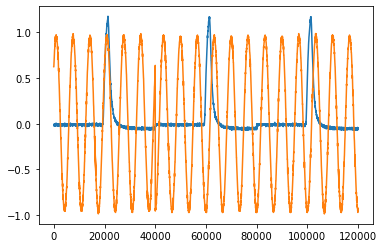

In [6]:
plt.plot(chan1[:3 * n])
plt.plot(chan2[:3 * n])

In [7]:
dt = 0.005 #ns
f0 = 0.030 # GHz

In [8]:
t = dt * np.arange(n)
# check that the rf frequency is as expected
def func(x, A, B, f):
    return A * np.cos(2 * np.pi * f * x) + B * np.sin(2 * np.pi * f * x)

popt, pcov = curve_fit(func, t, ch2[0], p0=[0, 1,f0])
popt

array([0.60734919, 0.73828265, 0.03000962])

In [9]:
X = np.vstack([np.cos(2 * np.pi * f0 * t), np.sin(2 * np.pi * f0 * t)]).T
y = ch2[0]
res = np.linalg.lstsq(X, y, rcond=None)
Afit, Bfit = res[0]

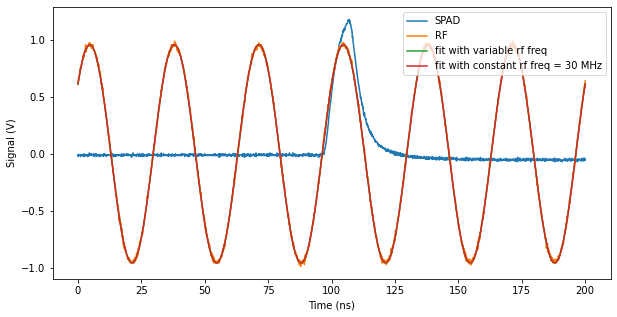

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
t = dt * np.arange(n)
ax.plot(t, ch1[0], label='SPAD')
ax.plot(t, ch2[0], label='RF')
ax.plot(t, func(t, *popt), label="fit with variable rf freq")
ax.plot(t, func(t, Afit, Bfit, f0), label="fit with constant rf freq = 30 MHz")
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Signal (V)')
ax.legend()
plt.show()

In [13]:
phases = []
for y in ch2:
    res = np.linalg.lstsq(X, y, rcond=None)
    Afit, Bfit = res[0]
    phases.append(np.angle(Afit + 1j * Bfit))

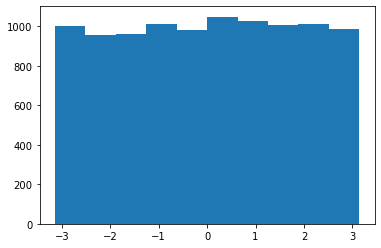

In [14]:
plt.hist(phases)
plt.show()